*** Install the <a href='https://anaconda.org/conda-forge/jupyterlab-plotly-extension'> extension of plotly for jupyter lab</a> if some plot is not showing in the end of the notebook.***<br>


# Data collection:

   <b> Our data are collected from 5 sources: </b>
<ul>
    <li> Google BigQuery
    <li>StackOverflow Annual Developper Survey (from 2012 to 2018)<a href='https://insights.stackoverflow.com/survey'> StackOverflow Annual Developper Survey</a>
    <li>StackExchange archives   <a href="https://archive.org/download/stackexchange" >Archive Org</a>   
    <li>World Bank Open Data /UN Data/ Kaggle <a href="https://data.worldbank.org" >World Bank</a>                   
    <li>Unstructured data scraped from wikipedia and other sites

</ul>

### StackOverflow Annual Developper Survey:
StackOverflow Annual Developper Survey contains more than 60 qusetions(questions vary each year), and number of people participating are as follows:


| Year | Number of responses   |Number of Questions|
|------|------|-----|
|2012   | -|   -|
|2013   | 9743|   128|
|2014   | 7644|   120|
|2015   | 26087|   222|
|2016   | 56030|   66|
|2017   | 51392|   154|
|2018   | 98855|   129|


Survey Questions include: 'Professional', 'ProgramHobby', 'Country', 'University',
       'EmploymentStatus', 'FormalEducation' etc.
       
Since the schema is too different for years before 2016, we will only use the recent 4 years, i.e. 2016 - 2019, survey data in our analysis. 

### Google BigQuery:

We queried from BigQeury 3 datasets:
<ol>
    <li>data of answers created between 2016 and 2019  (588.2MB)
        <img src="./notebook_figures/answers.png" alt="Alt text that describes the graphic" title="Title text" />
    <li>data of questions created between 2016 and 2019 (624.8MB)
        <img src="./notebook_figures/questions.png" alt="Alt text that describes the graphic" title="Title text" />
    <li>data of users registered between 2016 and 2019 (303.1MB)
        <img src="./notebook_figures/users.png" alt="Alt text that describes the graphic" title="Title text" />
</ol>

### World Bank Open Data/UN Data/Kaggle:

<ul>
    <li>Mean years of Schooling by country.csv  <a href='http://data.uis.unesco.org/Index.aspx?queryid=242'>  Education: Mean years of schooling</a>
        <li>GDP per capita by country.csv  <a href='https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?view=map'>GDP per capita (current US$)</a>
            <li> Population by country.csv   <a href='https://data.worldbank.org/indicator/sp.pop.totl'> population.total</a>
                <li > list-of-countries-by-number-of-internet-users.csv  <a href="https://www.kaggle.com/tanuprabhu/list-of-countries-by-number-of-internet-users" >list-of-countries-by-number-of-internet-users</a>
                
### StackExchange archives:
Currently, we have not used any data from the archives directly. But it could be a possible data source. <br>


| Dataset | Updating Date   |Size|
|------|------|-----|
|stackoverflow.com-Badges.7z	|02-Sep-2019 13:10	|233.9M|
|stackoverflow.com-Comments.7z	|02-Sep-2019 13:22	|4.1G|
|stackoverflow.com-PostHistory.7z	|03-Sep-2019 23:59	|24.4G|
|stackoverflow.com-PostLinks.7z	|03-Sep-2019 16:11	|82.1M|
|stackoverflow.com-Posts.7z	|04-Sep-2019 14:38	|13.9G|
|stackoverflow.com-Tags.7z	|03-Sep-2019 16:11	|787.6K|
|stackoverflow.com-Users.7z	|03-Sep-2019 16:27	|477.2M|
|stackoverflow.com-Votes.7z	|03-Sep-2019 16:34	|1.0G|

# Research Direction: <br>StackOverflow as a social network - User activity analysis

## Objective:
For most people doing coding today, Stack Overflow should not be an unfamiliar site. It is being used by thousands and potentially millions of people from all over the world each day to find solutions to problems. The main idea of our project is that it would be interesting to see what are the users of Stackoverflow really like and how are they distributed around the world? Which countries contribute the most to the site, and in which ways? The information could be very interesting to Stackoverflow itself, since it would allow them to understand the users potential areas for growth. Since Stackoverflow is such a large and widely used site for help in programming, it is also interesting in a wider perspective since the results could reflect something about how the programming community works as a whole.

Smaller Objective:
1. __Time Evolution of StackOverflow User commuity__<br>
StackOverflow has already a thorough analysis of its annual survey result, but primarily focused on a single year. In other words, we think some chronological persepectives and comparaisons could be done to complement the analysis already exists. In order to do so, we need to select the commom fields of all 4 years and concatenate these data of 4 years into a single dataset and try interpreting the temporal tendency.

2. __Geographical distribution__<br>
<ul>

<li>How are the users distributed geographically? 
Which countries have the highest amount of users? users per capita? active users?<br>
To answer these question, we make use of the SO survey data of a particular year, here 2016. (we may change it to 2018 to make it more recent)<br>
We plan to make some geographical visulizations in this part for <b>milestone3</b>.<br><br>

<li>StackOverflow as a question-answering website to some extent represents how knowlegde are shared and transported. Comibinng the <i>questions, answers, users</i> datasets, we should be able to draw flows of informations over a worldmap (arrows
 represent answers sent from one location to another location in the world )
 for <b>milestone3</b>.<br>For now, we have cleaned the dataset of users information, espeically the messy location data.<br><br> 

<li>In which countries are the users most active at asking questions and where are they most active at answering them? Are there countries where the users go to the site often but don't contribute that much? Do there exist patterns of questions asked in some countries being often answered in others? <b>milestone3</b>

</ul>

In [1]:
import re
import pycountry 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import country_converter as coco
import pycountry_convert as pc

from requests import get
from bs4 import BeautifulSoup
from html.parser import HTMLParser
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from countryinfo import CountryInfo

import dateutil.parser

%matplotlib inline

## Scraping data 

Average English level of a country should play a role in the popularity of SO among 
the people. English-speaking countires like UK, USA and Canada have a large user community 
compared to countries with similar size. Therefore we want to fetch a dataset representing
the English level of the countries in the world. We decide to scrape the 2019 EF_English_Proficiency data from wikipedia page

In [211]:
EF_English_Proficiency = get('https://en.wikipedia.org/wiki/EF_English_Proficiency_Index', 'lxml')

''' Grabbing the country names, scores and ranks '''
EF_English_Proficiency = BeautifulSoup(EF_English_Proficiency.text, 'html.parser')

EF_English_Proficiency=EF_English_Proficiency.table

country_list=[p.text for p in EF_English_Proficiency.find_all('a') ] 

country_list=[country for country in country_list if country!='']

headers=[p.text for p in EF_English_Proficiency.find_all('th') ] 

contents=[p.text.strip() for p in EF_English_Proficiency.find_all('td') ] 

"""In total there are 100 countries involed in the 2019 EF_English_Proficiency
evaluation. All of them are retrived. """
score_list=[]
rank_list=[]
for i in range(int(len(contents)/4)):
    rank_list.append(contents[4*i])
    score_list.append(contents[4*i+2])

d = {'Country': country_list,'2019 Score':score_list}

EF_English_Proficiency=pd.DataFrame(d)

EF_English_Proficiency survey is targeted to non-anglosphere countries, so countries
with English as native language like USA, UK, Canada,are not involved. In order to 
complement the English-level dataset, we scrape the TOEFL-exempt countries list from 
'https://graduate.seas.gwu.edu/toefl-exempt-countries' . And we fill the EF_English_Proficiency
score of these countries by 85(much higher than the best score in the EF list,i.e. 70 
for Netherlands)  

In [212]:
TOEFL_exempt=get('https://graduate.seas.gwu.edu/toefl-exempt-countries')
TOEFL_exempt = BeautifulSoup(TOEFL_exempt.text, 'html.parser')
TOEFL_exempt=TOEFL_exempt.find("div", {"class": "general-content-primary"})
country_list_sup=[p.text for p in TOEFL_exempt.find_all('li') ] 

country_list_sup.extend(['United States','Canada','Ireland'])

score_list_sup=85*np.ones(len(country_list_sup))

d_sup = {'Country': country_list_sup,'2019 Score':score_list_sup}
EF_English_Proficiency_sup=pd.DataFrame(d_sup)

EF_English_Proficiency=pd.concat([EF_English_Proficiency,EF_English_Proficiency_sup]) 
EF_English_Proficiency['code']=EF_English_Proficiency.Country.apply(lambda x: coco.convert(names=x,to='ISO3') )

EF_English_Proficiency.to_pickle('../project_dataset/EF_English_Proficiency.pkl')

# Data Preprocessing :

<ul>
<li><b>StackOverflow Annual Developper Survey:</b><br>
The raw data contains a large percenage of NaN values in many rows and columns. This is comprehensible since the data is collected under the form of a survey so users may skip quite a lot questions. A preprocesssing to remove NaN and eventually fill NaN by a value is necessary for the following analysis.<br>
    
In addition, there are different questions in the user survey for each year. It is important to unify the data representation so as to make the comparison of the years easier. <br>

Most of the answers are categorical. A mapping from categories to numerical values maybe necessary if some Machine Learning regression tasks will be performed.<br><br>
    
<li><b>Google BigQuery:</b><br>
The data obtained from Google BigQuery is overall well structured and cleaned, except the location data in the <i>Users</i> file. Idealy, the location value of each user should be "city name + country name " or simply "country name" and should be writen in English, thus like the following ones: "Moscow, Russia", "Michigan, United States","Bangladesh" etc. However, the real state of location data is much more complexe, we have typically data like these:
<ul> 
<li><i><b>Deutschland,España,Россия,日本、東京都中央区日本橋室町</i></b>,i.e. country name in the local language rather than English
<li> <i><b>munich,Shanghai </i></b>, i.e. only city name without country name
<li> <i><b>Perth 西澳大利亚州澳大利亚,  Algérie</i></b>, i.e. location name in another language rather than the local language nor English.
<li> <i><b> Sigapore </i></b>, i.e.Spelling error
<li> <i><b> Internet, Somewhere, Browser, Earth City ,In the desert eating dessert contemplating whether I should desert...</i></b>, i.e.Non Sense Values
<li> <i><b> Bulgaria/Denmark, Germany and Norway </i></b>, i.e. double location
</ul><br>

<li><b>World Bank Open Data /UN Data/ Kaggle World Bank:</b><br>
These data are typically of small size and easy to handle. We will discuss them one by one in detail in the comments of codes.<br><br>
    
<li><b>StackExchange Archives:</b><br>
We haven't made any use of these data. Thus no preprocessing is done for the moment, but similarly to the data obtained from Google BigQuery, these data are globally well structured and well cleand.

## Preprocessing survey data

There are 4 years of user survey data we'll be using and we will clean the 4 years to have the same schema. However, here we will just show some exploratory statstics on the data of one year to show how the data is like since cleaning the data took time and we thought that starting work on exploring the data early enough was important. In the future we plan to move to the cleaned dataset. The detailed cleaning code will be in 'survey_cleaning.ipynb'. 
<b><center>What the final schema will look like:</center></b>

    
| Field | Description | Possible Values |
|-------|-------------|-----------------|
| Hobby  | Whether the user code as a hobby | Yes / No |
| Country  | The country the user is from | Country Code in iso3 format |
| YearsCoding | How many years of experience the user have with coding | '0 - 2 years', '2 - 5 years', '6 - 10 years', '11+ years' |
|JobSatisfaction|The level of satisfaction of the user towards their job | real numbers from 1 to 7, 0 if the user does not fill this field|
|ConvertedSalary|Salary of the user in USD|positive real numbers, 0 if the user does not fill this field|
|LanguageWorkedWith|The language that the user use extensively recently|List of programming languages or empty list|
|LanguageDesireNextYear|The language that the user wants to work with|List of programming languages or empty list|
|Gender|Gender of the user|'Male', 'Female', 'Transgender', 'Prefer not to disclose'|
|StackOverflowVisit|Visit frequency to stackoverflow of the user |'I have never visited Stack Overflow (before today)', 'Multiple times per day', 'Daily or almost daily', 'A few times per week', 'A few times per month or weekly', 'Less than once per month or monthly'|
|StackOverflowParticipate|Participation frequency to stackoverflow of the user (ask/answer questions, voting, commenting etc)| 'I have never visited Stack Overflow (before today)', 'Multiple times per day', 'Daily or almost daily', 'A few times per week', 'A few times per month or weekly', 'Less than once per month or monthly'|
|Year|The year that the data is obtained| 2016, 2017, 2018, 2019|
|Age*| The age of the user| real numbers|

*: Only the age field of year 2019 is kept, as the age field is missing in year 2017 and the values in 2016 and 2018 are in different categorical representation. We have decided to only keep the age data of year 2019 since the values here are in real numbers and we think probably the user doing the survey are similar across the years that it may cause some heavy bias if all 4 years are kept.

### Getting the data for 2016 for analysis in this notebook.

In [2]:
# to download the survey data of 2016 :
# https://drive.google.com/file/d/117TtVjOoRp483y9Lujqx9ropv7XXJ56Z/view?usp=sharing

# read the 2016 data and drop the ones that have less than 10 non-na fields 
path16 = './data/2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Responses.csv'
survey16 = pd.read_csv(path16)
survey16.dropna(thresh=10,inplace=True)

In [3]:
survey16.columns

Index(['Unnamed: 0', 'collector', 'country', 'un_subregion', 'so_region',
       'age_range', 'age_midpoint', 'gender', 'self_identification',
       'occupation', 'occupation_group', 'experience_range',
       'experience_midpoint', 'salary_range', 'salary_midpoint',
       'big_mac_index', 'tech_do', 'tech_want', 'aliens',
       'programming_ability', 'employment_status', 'industry',
       'company_size_range', 'team_size_range', 'women_on_team', 'remote',
       'job_satisfaction', 'job_discovery', 'dev_environment',
       'commit_frequency', 'hobby', 'dogs_vs_cats', 'desktop_os',
       'unit_testing', 'rep_range', 'visit_frequency', 'why_learn_new_tech',
       'education', 'open_to_new_job', 'new_job_value', 'job_search_annoyance',
       'interview_likelihood', 'how_to_improve_interview_process',
       'star_wars_vs_star_trek', 'agree_tech', 'agree_notice',
       'agree_problemsolving', 'agree_diversity', 'agree_adblocker',
       'agree_alcohol', 'agree_loveboss', 'agree_n

In [4]:
# getting the fields of interest and save it to pickle
survey16_cleaned=survey16[['country','job_satisfaction', 'tech_do', 'tech_want', 'visit_frequency','age_range'
         ,'gender', 'hobby', 'experience_range','experience_range','salary_midpoint']].dropna(thresh=5)
survey16_cleaned.to_pickle('survey2016_cleaned.pkl')

## Preprocessing BigQuery data
Since cleaning the location field of the users to get their respective countries was quite complicated, we have placed the analysis in the notebook titled 'clean_user_country.ipynb'. The main idea was to use a dataset of country names in different languages, as well as a dataset consisting of city names and their respective administrative area names in English. These were used in steps of increasing complexity to try to get as many of the user countries extracted from the data. 

# Analysis of the 2016 survey data

## Distribution by programming language

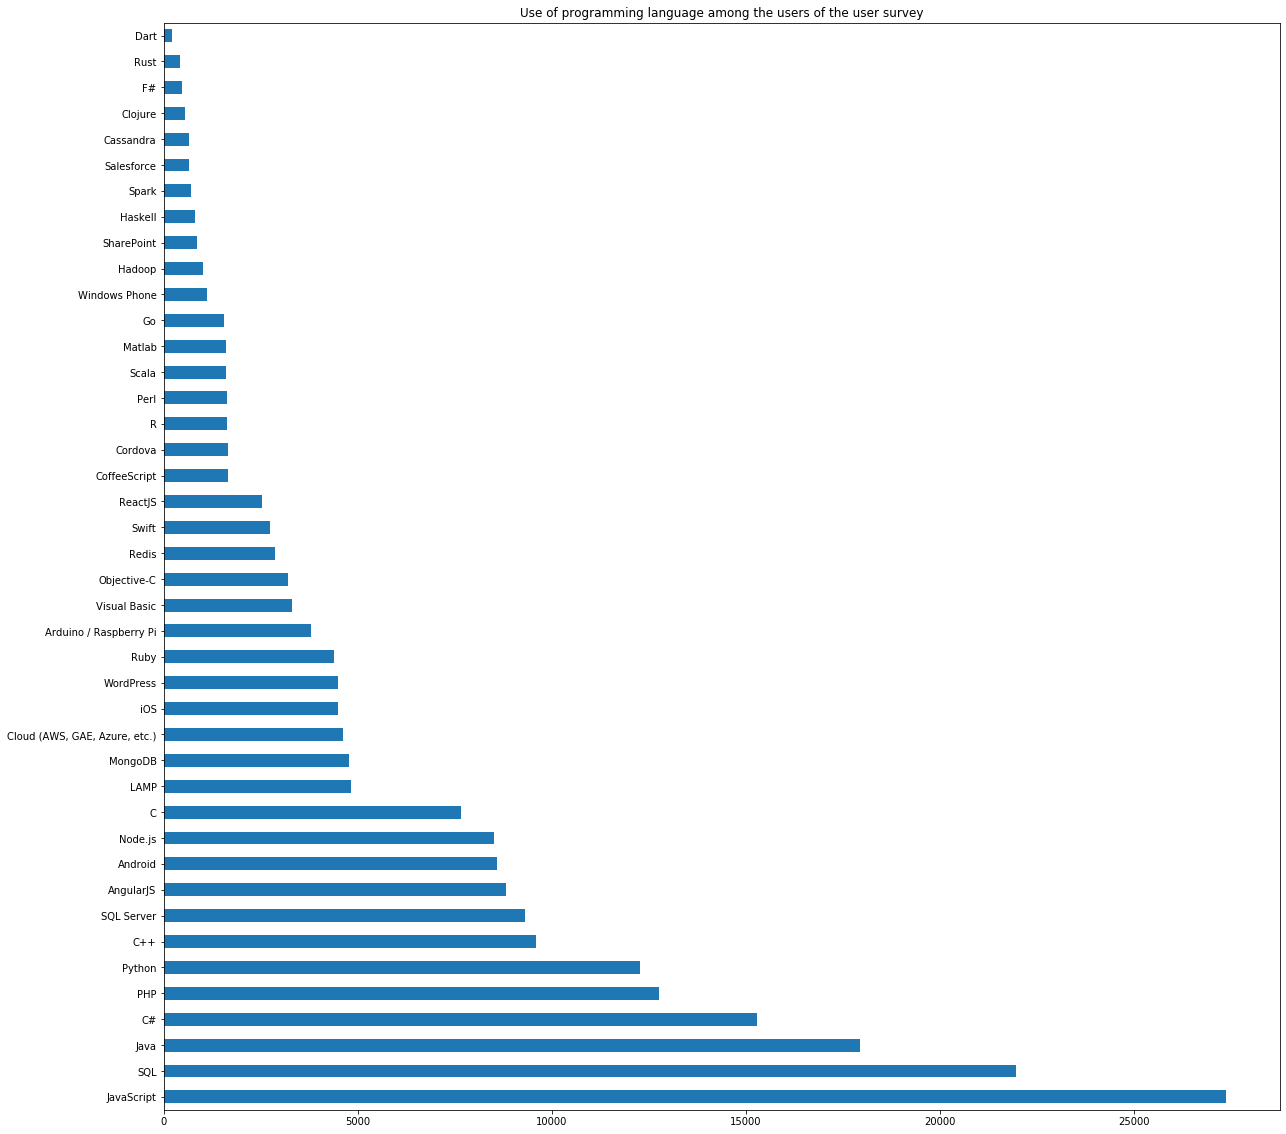

In [5]:
# plot the frequency distribution of programming language 

fig = plt.figure(figsize=(20, 20))
survey16.tech_do.dropna().apply(lambda x: str(x).split('; ')).explode(
).value_counts().sort_values(ascending=False).plot.barh()
plt.title('Use of programming language among the users of the user survey')
plt.show()

## Distribution by visit frequency

In [6]:
survey16.visit_frequency.unique()

array(['Multiple times a day', 'Once a week', nan, 'Once a day',
       'Very rarely',
       'I have never been on Stack Overflow. I just love taking surveys.',
       'Once a month'], dtype=object)

In [7]:
survey16.visit_frequency = survey16.visit_frequency.astype('category').cat.set_categories([
    'I have never been on Stack Overflow. I just love taking surveys.',
    'Very rarely', 'Once a month', 'Once a week', 'Once a day','Multiple times a day'], ordered=True)

In [8]:
ByCountryCount=survey16.groupby(['country']).count()
display(ByCountryCount.rename(columns={'Unnamed: 0': 'User Count'})['User Count'].sort_values(ascending=False))

country
United States     13445
United Kingdom     4520
India              4151
Germany            3848
Canada             2013
                  ...  
Rwanda                1
Namibia               1
Chad                  1
Niger                 1
Guinea                1
Name: User Count, Length: 167, dtype: int64

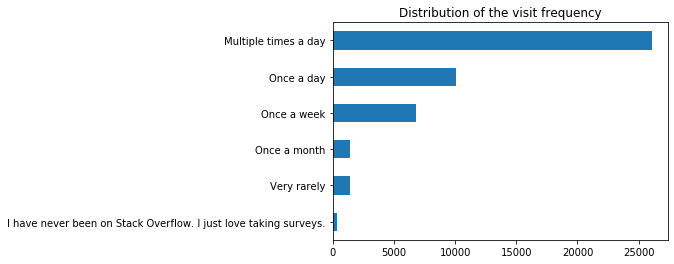

In [9]:
visit_frequency=survey16.visit_frequency[pd.notna(survey16.visit_frequency)].value_counts().sort_values()

visit_frequency.plot.barh()
plt.title('Distribution of the visit frequency')
plt.show()

### Correlation of visit frequency with other factors

In [10]:
frequencydf=survey16.groupby(by='visit_frequency').mean()[['experience_midpoint', 'age_midpoint',
                                               'programming_ability']].reset_index()\
                                                .sort_values(by='visit_frequency')

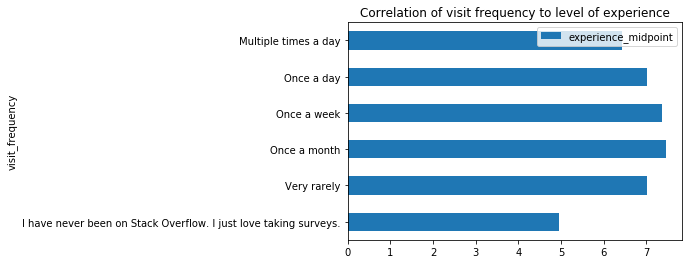

In [11]:
# correlation of visit frequency to level of experience
frequencydf.plot.barh(x="visit_frequency",y="experience_midpoint")
plt.title('Correlation of visit frequency to level of experience')
plt.show()

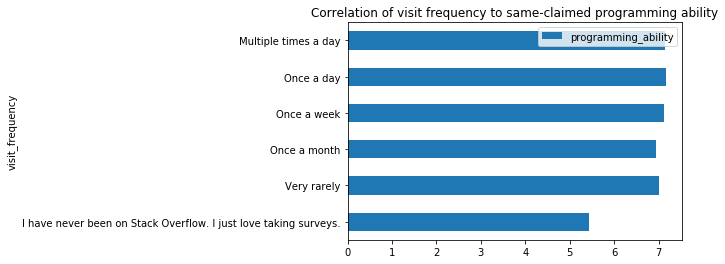

In [12]:
# correleation of visit frequency to claimed programming ability
frequencydf.plot.barh(x="visit_frequency",y="programming_ability")
plt.title('Correlation of visit frequency to same-claimed programming ability')
plt.show()

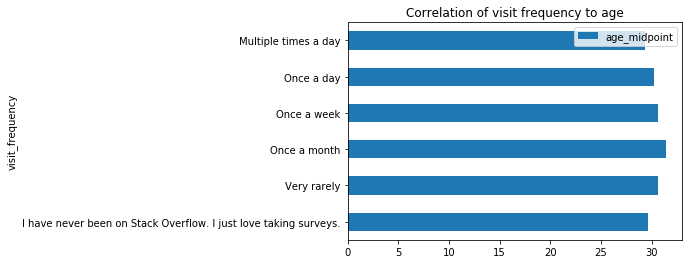

In [13]:
# correleation of visit frequency to age group
frequencydf.plot.barh(x="visit_frequency",y="age_midpoint")
plt.title('Correlation of visit frequency to age')
plt.show()

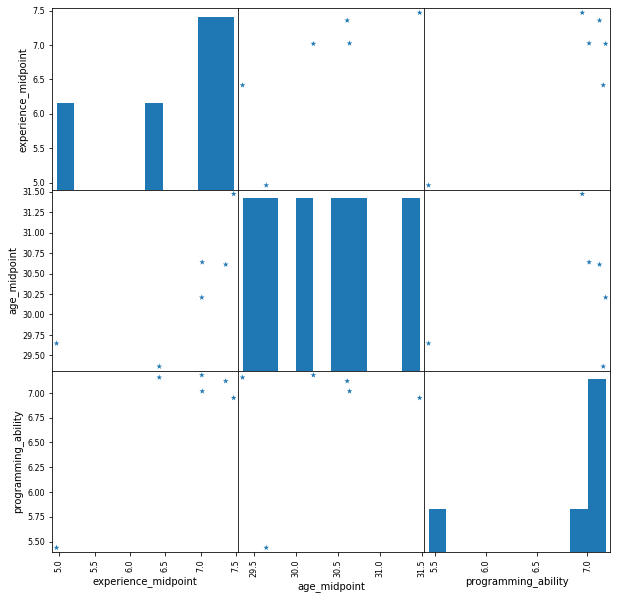

In [14]:
# correlation matrix
pd.plotting.scatter_matrix(frequencydf, alpha=1,figsize=(10,10),marker='*')
plt.show()

### We have found out there are not obvious correlation among age, level of experience and the self-proclaimed programming ability with the visit frequency. 

## Distribution of company size of stackoverflow users

In [15]:
# drop entries with NaN and of which the content is not in the form ______ employees
company_size_range=survey16.company_size_range.dropna()[survey16.company_size_range.dropna().str.endswith('employees')]
company_size_range

1        100-499 employees
3        100-499 employees
7          10-19 employees
9            5-9 employees
11       100-499 employees
               ...        
56012        5-9 employees
56017      20-99 employees
56019      20-99 employees
56022      10-19 employees
56029      20-99 employees
Name: company_size_range, Length: 38136, dtype: object

In [16]:
# raw distribution of company size of interviewers
company_size_range.value_counts()

20-99 employees          8615
100-499 employees        6801
10,000+ employees        4707
10-19 employees          3972
1-4 employees            3701
1,000-4,999 employees    3596
5-9 employees            3069
500-999 employees        2304
5,000-9,999 employees    1371
Name: company_size_range, dtype: int64

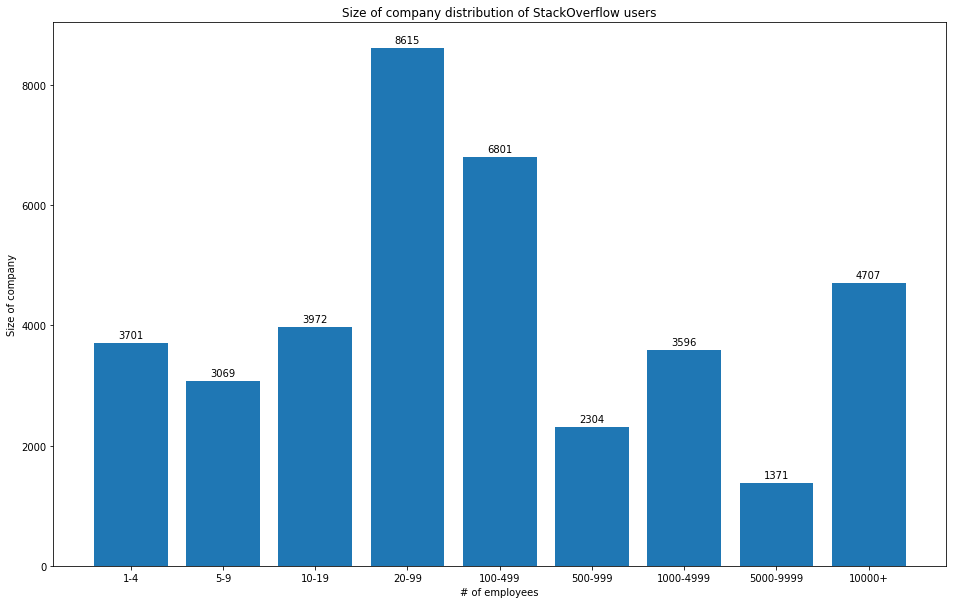

In [17]:
# sort the category and output the value counts accordingly
No_by_Category=company_size_range.apply(lambda x: (
    re.match(r'(.+)[-+]', str(x)).group(0)[:-1])).apply(
    lambda a: int(a.replace(',', ''))).value_counts().sort_index().tolist()

# visualization of distribution of company size
fig,ax=plt.subplots(figsize=(16,10))
labels = ['1-4', '5-9', '10-19', '20-99', '100-499','500-999','1000-4999','5000-9999',
         '10000+']
rects=ax.bar(range(len(No_by_Category)),No_by_Category)


# add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Size of company')
ax.set_xlabel('# of employees')
ax.set_title('Size of company distribution of StackOverflow users')
ax.set_xticks(range(len(No_by_Category)))
ax.set_xticklabels(labels)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

## Distribution by geographic location

The stackoverflow user survey data could be merged with some general geographical data to gain more insights onto the reason behind the number of users. Also, the geographical data is important since ultimately we want to combine the dataset with the actual Stackoveflow data, and the only field that allows us to make the connection is the countries of the users and the people who answered the survey.

### Processing the country field
Here we use a python library "country converter" for extracting the countries of the users in more easily dealt-with ISO3-format.

In [18]:
survey16['country']
country=pd.DataFrame(survey16.country.dropna().value_counts())
country.reset_index(inplace=True)
country.rename({'country':'UserNumber','index':'country'},axis='columns',inplace=True)

In [19]:
# convert the country field into iso3 format and add the population information about the country to the daraframe
country['code']=country.country.apply(lambda x: coco.convert(names=x,to='ISO3') )

### Getting other relevant datasets

Here we load other possibly relevant datasets for our analysis now and in the future, namely the populations of countries, data on amount of internet users and levels of education, and combine them in to one usable dataframe. 

In [20]:
# add the population data by group
path_pop='./data/population_worldbank.csv'
population_stats=pd.read_csv(path_pop,skiprows=2,header = 1
                            ).drop(['2019','Unnamed: 64'],axis=1).dropna()

country=country.merge(population_stats[['Country Code','2018']],left_on='code',right_on='Country Code',how='left')
country.rename({'2018':'population18(million)'},axis='columns',inplace=True)
country['population18(million)']=country['population18(million)']/1e6

In [21]:
# calculate user per capital from the user survey 
country['User per capita index']=country['UserNumber']/country['population18(million)']
country.drop(columns='Country Code',inplace=True)

In [22]:
# add number of internet users data into the dataframe 
path='./data/Countries by number of Internet Users - Sheet1.csv'
internetUsers_stats=pd.read_csv(path).dropna()

In [23]:
path='./data/education.csv'
education=pd.read_csv(path)

In [24]:
education=education.groupby(by='Country').mean().drop(['TIME', 
     'Time', 'Flag Codes', 'Flags'],axis=1)

In [25]:
# add education data into the dataframe 
education.rename(columns={'Value':'mean year by school'},inplace=True)
education['country']=education.index
education['code']=education.country.apply(lambda x: coco.convert(names=x,to='ISO3') )

Let's have a look at the loaded data.

In [26]:
education.columns

Index(['mean year by school', 'country', 'code'], dtype='object')

In [27]:
internetUsers_stats['code']=internetUsers_stats['Country or Area'].apply(lambda x: coco.convert(names=x,to='ISO3') )

In [28]:
# rename the columns names to avoid ambiguities
internetUsers_stats.rename(columns={'Rank':"Rank # users",'Rank.1':'Rank percentage'
                            ,'Percentage':'Internet Percentage'},inplace=True)
internetUsers_stats=internetUsers_stats[internetUsers_stats['Rank percentage']!='-']

In [29]:
internetUsers_stats

Country or Area Internet Users     Population  Rank # users  \
0             China    765,367,947  1,409,517,397             1   
1             India    461,347,554  1,339,180,127             2   
2     United States    244,090,854    324,459,463             3   
3            Brazil    141,206,801    209,288,278             4   
4             Japan    115,845,120    127,484,450             5   
..              ...            ...            ...           ...   
206        Anguilla         12,043         14,909           207   
207           Nauru          6,475         11,359           208   
208          Tuvalu          5,520         11,192           209   
211      Montserrat          2,833          5,177           212   
213            Niue          1,034          1,618           214   

    Internet Percentage Rank percentage code  
0                54.30%             116  CHN  
1                34.45%             145  IND  
2                75.23%              68  USA  
3                67.47%              83  BRA  
4                90.87%              23  JPN  
..                  ...             ...  ...  
206       81.57% (2016)              44  AIA  
207              57.00%             110  NRU  
208              49.32%             124  TUV  
211       54.55% (2013)             115  MSR  
213       86.90% (2013)              30  NIU  

[209 rows x 7 columns]

In [30]:
internetUsers_stats.columns

Index(['Country or Area', 'Internet Users', 'Population', 'Rank # users',
       'Internet Percentage', 'Rank percentage', 'code'],
      dtype='object')

In [31]:
country=country.merge(internetUsers_stats[['Internet Users','Rank # users',
       'Internet Percentage', 'Rank percentage','code']],left_on='code',right_on='code',how='left')

country=country.merge(education[['mean year by school','code']],left_on='code',right_on='code',how='left')

In [32]:
country.to_pickle('./data_ML')

In [33]:
# load the data for ML if needed
# country=pd.read_pickle('./data_ML')

# drop the mean year by school column as there are too many null values, including Canada and India
country.drop(columns='mean year by school',inplace=True)

# drop countries with NaN, incluing Vatican, Kosova, North Korea(all small countries, total 9 countries 
country.dropna(inplace=True)

# check if all rows containing null in any of the columns are removed
country.isnull().any()

country                  False
UserNumber               False
code                     False
population18(million)    False
User per capita index    False
Internet Users           False
Rank # users             False
Internet Percentage      False
Rank percentage          False
dtype: bool

In [34]:
# merge with english proficiency score as stackoverflow are mostly in english, proficiency may affect the
# usage rate of stackoverflow
EF_English_Proficiency=pd.read_pickle('./data/EF_English_Proficiency.pkl')

country=country.merge(EF_English_Proficiency[['2019 Score',
       'code']],left_on='code',right_on='code',how='left')
country.rename({'2019 Score':'2019 EF Score'},axis='columns',inplace=True)

country.set_index('country',drop=False)

country['2019 EF Score']=country['2019 EF Score'].astype('float')

country.fillna(value=country['2019 EF Score'].mean(),inplace=True)

In [35]:
path='./data/gdp_per_capita.csv'
gdp_per_capita=pd.read_csv(path,usecols=['Country Code','2018','2017','2016'],header=2)

gdp_per_capita['gdp per capita']=gdp_per_capita[['2016','2017','2018']].mean(axis=1,skipna=True)

country=country.merge(gdp_per_capita[['gdp per capita',
       'Country Code']],left_on='code',right_on='Country Code',how='left')

country['Internet Percentage']=country['Internet Percentage'].str.strip('%').astype('float')

'''
Countries arranged by Number of Universities in Top Ranks
https://www.webometrics.info/en/node/54
''';

country.fillna(value=country['gdp per capita'].mean(),inplace=True)

In [36]:
country.to_pickle('./country_for_ML.pkl')

### Plotting stackoverflow users distribution by countries 

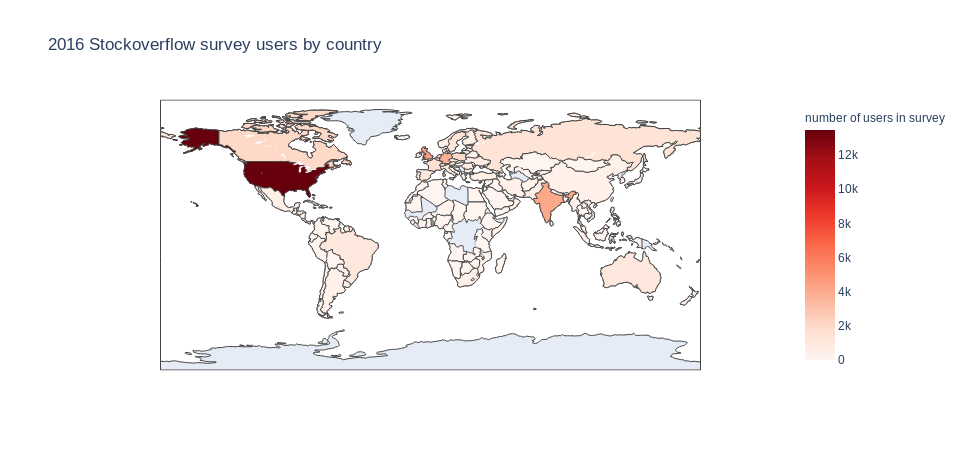

In [58]:
import plotly.graph_objects as go

fig1 = go.Figure(data=go.Choropleth(
    locations=country['code'], # Spatial coordinates
    z = country['UserNumber'], # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "number of users in survey",
))

fig1.update_layout(
    title_text = '2016 Stockoverflow survey users by country',geo_scope="world"
)

fig1.show()


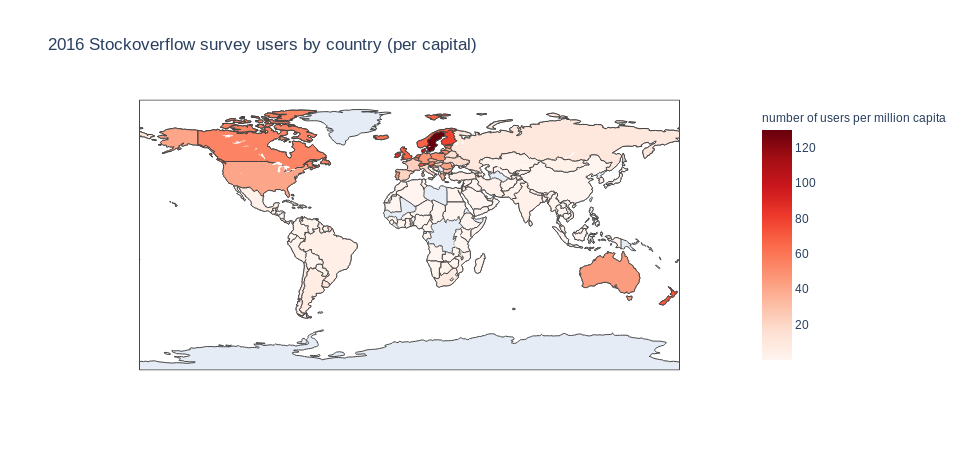

In [62]:
fig2 = go.Figure(data=go.Choropleth(
    locations=country['code'], # Spatial coordinates
    z = country['User per capita index'], # Data to be color-coded
    colorscale = 'Reds',
    colorbar_title = "number of users per million capita",
))

fig2.update_layout(
    title_text = '2016 Stockoverflow survey users by country (per capital)',geo_scope="world"
)

fig2.show()

## Strange Observation: Chinese Stackoverflow User

The result of StackOverflow Survey showed that the number of users of Stackoverflow in China is <b>ranked 34th</b> , thus <b>between Norway and Iran, only 1/15 of users in India</b>. This is apparently a surprising result provided the population, number of programmers in China. This may due to some actual facts that China does large scale internet censorship, which may  not necessarily block the Stackoverflow but certainly slow down the visit of Stackoverflow from mainland China. This might cause that the actual 
number of users of Stackoverflow in China is <b>significently lower </b>than other countries like India,
USA or Brazil.  <br><br>
We could use machine learning algorithm to get a better sense about Chinese stackoverflow users (in milestone 3 most likely) .

<ol>
<li> Potential statisical data of world countries as features for regression. Including:
<ul>
<li>Internet penertration rate,
<li>population,
<li>mean schooling years,
<li>gdp per capita,
<li>Average English Level, etc
</ol>

## Distribution by Age Range


In [39]:
age_range=pd.DataFrame(survey16.age_range.dropna().value_counts())
age_range.reset_index(inplace=True)
age_range.rename({'age_range':'Number','index':'age_range'},axis='columns',inplace=True)

In [40]:
age_range

age_range  Number
0                   25-29   15363
1                   20-24   12687
2                   30-34    9837
3                   35-39    5554
4                   40-49    4848
5                    < 20    3805
6                   50-59    1609
7                    > 60     399
8  Prefer not to disclose     305

In [41]:
list(age_range.age_range.to_list())

['25-29',
 '20-24',
 '30-34',
 '35-39',
 '40-49',
 '< 20',
 '50-59',
 '> 60',
 'Prefer not to disclose']

In [42]:
age_range.age_range = age_range.age_range.astype('category').cat.set_categories([
    '< 20', '20-24', '25-29', '30-34', '35-39', '40-49', '50-59', '> 60', 'Prefer \
    not to disclose'], ordered=True)

In [43]:
age_range['age_range']=age_range['age_range'].sort_values()

In [44]:
age_range.sort_values(by='age_range',inplace=True)

age_range["age_range"] = age_range["age_range"].astype('category')

age_range.sort_values(by='age_range',inplace=True)
#age_range['m'] = pd.Categorical(df['m'], ["March", "April", "Dec"])

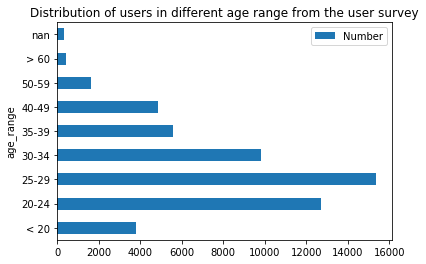

In [45]:
age_range.plot.barh(x='age_range',y='Number')
plt.title('Distribution of users in different age range from the user survey')
plt.show()

In [46]:
# mid point of the age of the users in user survey
survey16.groupby(['country']).mean().age_midpoint

country
Afghanistan    29.865385
Albania        24.608696
Algeria        27.129630
Andorra        32.000000
Angola         23.166667
                 ...    
Venezuela      29.797619
Vietnam        27.401709
Yemen          43.500000
Zambia         27.000000
Zimbabwe       31.388889
Name: age_midpoint, Length: 167, dtype: float64

## Active user analysis visit frequency and country

In [47]:
# count users whose visit frequency is 'Multiple times a day'(active users) and group them by country 
active_users=survey16[survey16['visit_frequency'].isin(['Multiple times a day'])].groupby(
    'country').count().sort_values(by='collector', ascending=False).reset_index()\
[['country', 'collector']].rename({'collector':'active_users'},axis=1)

# merge this table "active users number by country" with the one about "users number by country"
active_users=active_users.merge(country[['country','UserNumber']],left_on='country',right_on='country')

In [48]:
# create a new column representing the rate of active users by country
active_users['active_rate'] = active_users['active_users'] / \
    active_users["UserNumber"]

# remove countries of which the participants are less than 100 to avoid random risk
active_users = active_users[active_users['UserNumber'] > 100].sort_values(
    by='active_rate', ascending=False).reset_index(drop=True)

# add "code" column to represent the country 3 letter code (this will be useful for plotting maps)
active_users['code']=active_users.country.apply(lambda x: coco.convert(names=x,to='ISO3') )

# add corresponding continent code to each country
active_users['cont']=active_users['code'].apply(lambda x : pc.country_alpha2_to_continent_code\
                                                (pc.country_alpha3_to_country_alpha2(x)))

In [49]:
active_users['color']=active_users['cont'].map({'AS':"blue","SA":'green',"EU":'red','NA':'yellow'
                                                ,'AF':'cyan','OC':'orange'})

In [64]:
print('Top 20 most active country in stackoverflow by user rate in survey 2016:')
active_users.head(20)

Top 20 most active country in stackoverflow by user rate in survey 2016:


country  active_users  UserNumber  active_rate code cont  color  \
0      Indonesia           100         143        0.699  IDN   AS   blue   
1     Bangladesh           104         151        0.689  BGD   AS   blue   
2        Vietnam            79         117        0.675  VNM   AS   blue   
3      Singapore           110         166        0.663  SGP   AS   blue   
4       Bulgaria           137         213        0.643  BGR   EU    red   
5    Philippines           105         173        0.607  PHL   AS   blue   
6       Malaysia            72         124        0.581  MYS   AS   blue   
7       Pakistan           192         334        0.575  PAK   AS   blue   
8      Argentina           181         319        0.567  ARG   SA  green   
9         Brazil           573        1012        0.566  BRA   SA  green   
10         Egypt            59         105        0.562  EGY   AF   cyan   
11     Sri Lanka            60         110        0.545  LKA   AS   blue   
12         India          2234        4151        0.538  IND   AS   blue   
13         Japan            76         145        0.524  JPN   AS   blue   
14          Iran           163         313        0.521  IRN   AS   blue   
15        Turkey           224         434        0.516  TUR   AS   blue   
16         Spain           526        1022        0.515  ESP   EU    red   
17  South Africa           243         477        0.509  ZAF   AF   cyan   
18       Romania           418         822        0.509  ROU   EU    red   
19        Israel           220         437        0.503  ISR   AS   blue   

                                                 text  
0   Indonesia<br>active user proportion 69.8999999...  
1   Bangladesh<br>active user proportion 68.899999...  
2   Vietnam<br>active user proportion 67.5%<br>act...  
3   Singapore<br>active user proportion 66.3%<br>a...  
4   Bulgaria<br>active user proportion 64.3%<br>ac...  
5   Philippines<br>active user proportion 60.69999...  
6   Malaysia<br>active user proportion 58.09999999...  
7   Pakistan<br>active user proportion 57.49999999...  
8   Argentina<br>active user proportion 56.6999999...  
9   Brazil<br>active user proportion 56.5999999999...  
10  Egypt<br>active user proportion 56.2%<br>activ...  
11  Sri Lanka<br>active user proportion 54.5000000...  
12  India<br>active user proportion 53.80000000000...  
13  Japan<br>active user proportion 52.40000000000...  
14  Iran<br>active user proportion 52.1%<br>active...  
15  Turkey<br>active user proportion 51.6%<br>acti...  
16  Spain<br>active user proportion 51.5%<br>activ...  
17  South Africa<br>active user proportion 50.9%<b...  
18  Romania<br>active user proportion 50.9%<br>act...  
19  Israel<br>active user proportion 50.3%<br>acti...

In [54]:
active_users['active_rate']=active_users['active_rate'].round(3)

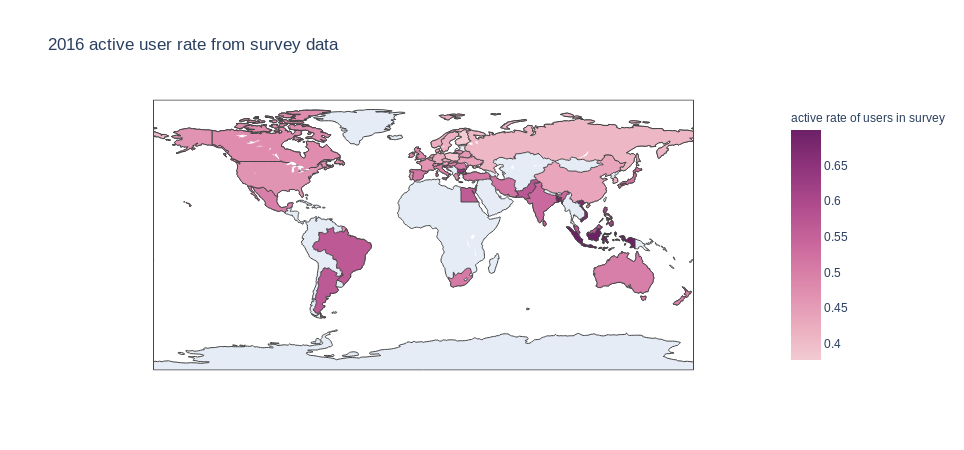

In [81]:
import plotly.graph_objects as go

active_users['text'] = active_users['country'] + '<br>active user proportion ' + (active_users['active_rate']\
                        *100).astype(str)+'%'+'<br>active user number '+(active_users['active_users'])\
                        .astype(str)+'<br>user number '+(active_users['UserNumber']).astype(str)

fig1 = go.Figure(data=go.Choropleth(
    locationmode = 'ISO-3',
    locations=active_users['code'], # Spatial coordinates
    z = active_users['active_rate'], # Data to be color-coded
    colorscale = 'magenta',
    text = active_users['text'],
    colorbar_title = "active rate of users in survey",
))

fig1.update_layout(
    title_text = '2016 active user rate from survey data',geo_scope="world"
)

fig1.show()

# Preliminary analysis of the Stackoverflow dataset
In this part, we do some preliminary analysis on the data downloaded from BigQuery.

## Short analysis on the user data

### Loading the data
Here we first load the dataset of users with cleaned location fields and add the name of the countries corresponding to their ISO3-codes.

In [2]:
users_df = pd.read_csv("data/stackoverflow_users_all_notext_clean.csv")
display(users_df.head())

"""Get dataset combining iso3-codes to country names in English"""
temp = pd.read_csv("data/IP2LOCATION-COUNTRY-MULTILINGUAL/IP2LOCATION-COUNTRY-MULTILINGUAL.CSV", 
                usecols=["LANG_NAME", "COUNTRY_ALPHA3_CODE", "COUNTRY_NAME"])
iso_to_name_df = temp[temp["LANG_NAME"] == "ENGLISH"]
iso_to_name_df = iso_to_name_df.drop("LANG_NAME", axis=1)\
    .rename({"COUNTRY_ALPHA3_CODE" : "iso3", "COUNTRY_NAME" : "country_name"}, axis=1)
iso_to_name_df.head()

Unnamed: 0       id  age                creation_date  reputation  \
0           0  7019478  NaN   2016-10-14 13:36:30.96 UTC           1   
1           1  7074992  NaN   2016-10-26 12:11:08.41 UTC           1   
2           2  7093392  NaN   2016-10-31 02:19:04.64 UTC           1   
3           3  7395536  NaN  2017-01-09 16:36:43.747 UTC           1   
4           4  7497308  NaN  2017-01-31 21:13:26.053 UTC           1   

   up_votes  down_votes country_iso3  
0         0           0          SGP  
1         0           0          EGY  
2         0           0          USA  
3         0           0          ROU  
4         0           0          NOR

iso3          country_name
3735  AND               Andorra
3736  ARE  United Arab Emirates
3737  AFG           Afghanistan
3738  ATG   Antigua and Barbuda
3739  AIA              Anguilla

In [3]:
"""Add the country name to users"""
users_df = users_df.merge(iso_to_name_df, left_on="country_iso3", right_on="iso3", how="inner").drop("iso3", axis=1)
users_df.head()

Unnamed: 0        id  age                creation_date  reputation  \
0           0   7019478  NaN   2016-10-14 13:36:30.96 UTC           1   
1         292   9688882  NaN  2018-04-24 03:33:59.517 UTC           1   
2         535   8095300  NaN  2017-06-01 02:59:42.433 UTC           1   
3        1137   3534296  NaN   2014-04-15 03:17:56.45 UTC           1   
4        1651  10991538  NaN  2019-01-30 16:31:00.287 UTC           3   

   up_votes  down_votes country_iso3 country_name  
0         0           0          SGP    Singapore  
1         0           0          SGP    Singapore  
2         0           0          SGP    Singapore  
3         0           0          SGP    Singapore  
4         0           0          SGP    Singapore

In [5]:
"""Parse the creation date field in to python-friendly format"""
users_df["creation_date"] = users_df["creation_date"].apply(lambda x: dateutil.parser.parse(x[:-4]))

In [6]:
"""Get users by country"""
users_by_country_df = users_df[users_df.country_iso3.notnull()].groupby("country_iso3").count().rename({"id":"count"},axis=1)[["count"]]
users_by_country_df = users_by_country_df.merge(iso_to_name_df, left_index=True, right_on="iso3")

### Geographical distribution of the users

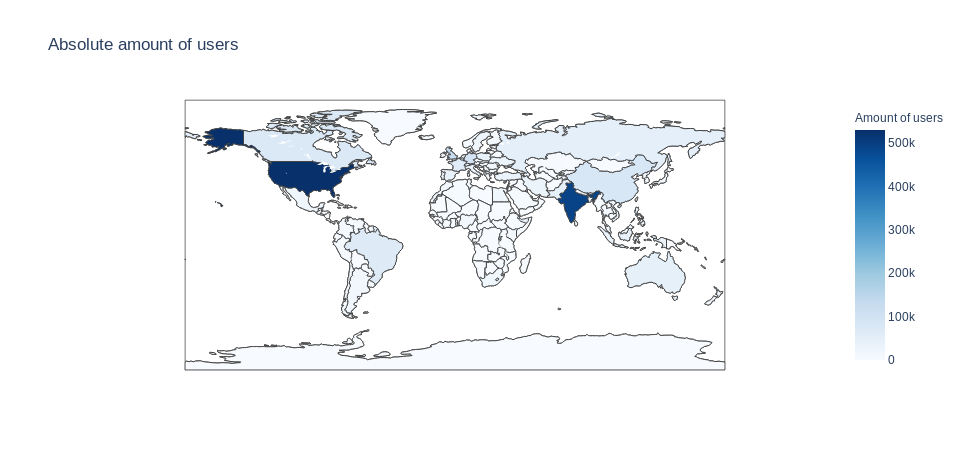

In [8]:
"""Plot absolute amount of users by country"""
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=users_by_country_df.iso3, # Spatial coordinates
    z = users_by_country_df['count'].astype(float), # Data to be color-coded
    text=users_by_country_df[['country_name', 'iso3']],
    colorscale = 'Blues',
    colorbar_title = "Amount of users",
))

fig.update_layout(
    title_text = 'Absolute amount of users'
)

fig.show()

Interestingly, for the absolute amount of actual users, India seems to be the second-largest country in the world, compared to Great Britain in the survey. It is also the case that India has almost the same amount of users as the US, while in the survey data people from the US were by far the largest group. 

## Analysis on question data
In this section, we show a basic analysis of the geographical distribution of questions and highlight possible future issues. A similar analysis can naturally be done on the answer data, this is just to show the how the analysis works in principle. 

### Loading the question data

In [9]:
"""Get questions data"""
questions_df = pd.read_csv('data/stackoverflow_questions_2016-2019_notext.csv')

In [10]:
questions_df.head()

Id  answer_count  comment_count                creation_date  \
0  34553230             1              0   2016-01-01 03:06:31.22 UTC   
1  34558566             1              0    2016-01-01 17:56:58.5 UTC   
2  34577016             1              0   2016-01-03 13:26:04.52 UTC   
3  34594608             1              0  2016-01-04 15:35:32.163 UTC   
4  34595235             1              0   2016-01-04 16:12:10.64 UTC   

   owner_user_id  score  view_count  favorite_count                       tags  
0       401226.0      0         256             NaN             pythonmacports  
1      2702781.0      1         256             NaN         scalasbtsbt-plugin  
2      4675736.0      0         256             NaN  phpcodeigniterlaravel-5.1  
3      1964648.0      0         256             NaN         c#azureazure-batch  
4      3232017.0      0         256             NaN      gitpermissionsgitblit

In [11]:
"""Get a new dataframe with country added"""
questions_countries = questions_df.merge(users_df[users_df.country_iso3.notnull()], left_on="owner_user_id", right_on="id")
questions_countries.columns

Index(['Id', 'answer_count', 'comment_count', 'creation_date_x',
       'owner_user_id', 'score', 'view_count', 'favorite_count', 'tags',
       'Unnamed: 0', 'id', 'age', 'creation_date_y', 'reputation', 'up_votes',
       'down_votes', 'country_iso3', 'country_name'],
      dtype='object')

In [12]:
"""Drop unnecessary fields"""
questions_countries.drop(["reputation", "up_votes", "down_votes", "creation_date_y", "Unnamed: 0"], inplace=True, axis=1)

In [13]:
"""Question count by country"""
question_counts_by_country_df = questions_countries.groupby("country_iso3").agg("count")[["Id"]].rename({"Id":"q_count"},axis=1)
question_counts_by_country_df = question_counts_by_country_df.merge(iso_to_name_df, left_index=True, right_on="iso3")

In [14]:
question_counts_by_country_df

q_count iso3   country_name
3748       14  ABW          Aruba
3737     1400  AFG    Afghanistan
3742      187  AGO         Angola
3749       35  ALA  Åland Islands
3740     1436  ALB        Albania
...       ...  ...            ...
3976       18  VUT        Vanuatu
3979      318  YEM          Yemen
3981    22103  ZAF   South Africa
3982      352  ZMB         Zambia
3983      977  ZWE       Zimbabwe

[232 rows x 3 columns]

### Geographical distribution of questions

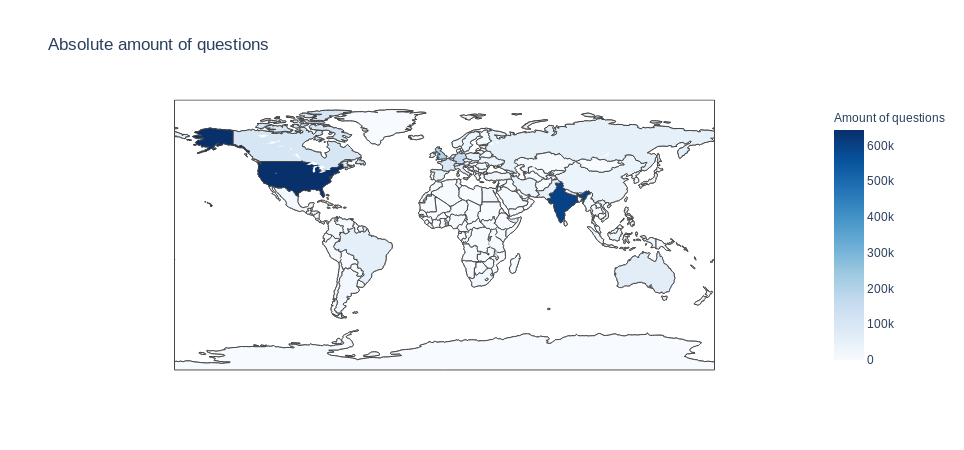

In [15]:
"""Plot absolute amount of questions"""
fig = go.Figure(data=go.Choropleth(
    locations=question_counts_by_country_df.iso3, # Spatial coordinates
    z = question_counts_by_country_df.q_count.astype(float), # Data to be color-coded
    text=question_counts_by_country_df.country_name,
    colorscale = 'Blues',
    colorbar_title = "Amount of questions",
))

fig.update_layout(
    title_text = 'Absolute amount of questions'
)

fig.show()

Looking at the above plot, it seems like the absolute amount of questions follows closely with the amount of users per country. Just looking at the colors on the plot, however, is not very accurate, so let's try plotting the amount of questions per user in each country. 

In [16]:
"""Combine question counts and user count datasets"""
question_counts_and_users_count_df = question_counts_by_country_df.merge(users_by_country_df[["count", "iso3"]], left_on="iso3", right_on="iso3")

In [17]:
"""Proportion of question counts and user counts"""
question_counts_and_users_count_df["proportion"] = question_counts_and_users_count_df["q_count"]/question_counts_and_users_count_df["count"]

In [18]:
question_counts_and_users_count_df.head()

q_count iso3   country_name  count  proportion
0       14  ABW          Aruba     40    0.350000
1     1400  AFG    Afghanistan   1127    1.242236
2      187  AGO         Angola    311    0.601286
3       35  ALA  Åland Islands     21    1.666667
4     1436  ALB        Albania   1562    0.919334

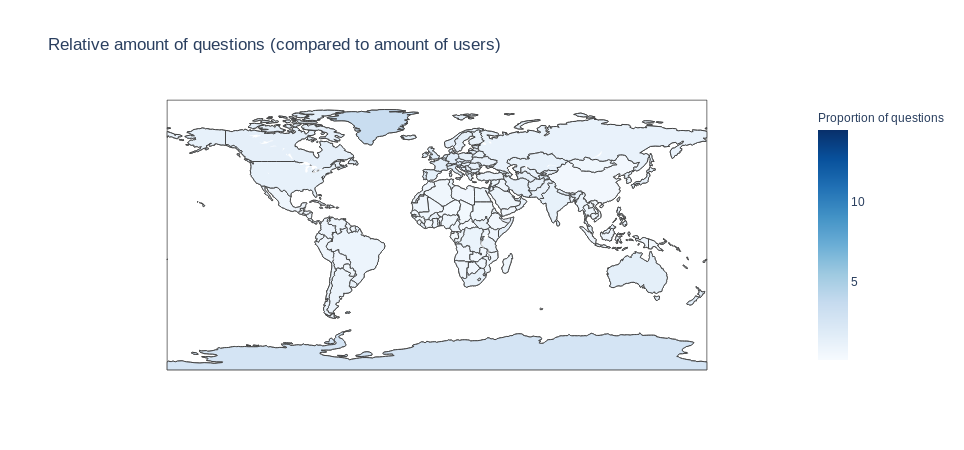

In [19]:
"""Plot relative question counts"""
fig = go.Figure(data=go.Choropleth(
    locations=question_counts_and_users_count_df["iso3"], # Spatial coordinates
    z = question_counts_and_users_count_df["proportion"], # Data to be color-coded
    text = question_counts_and_users_count_df[["country_name", "count", "q_count"]],
    colorscale = 'Blues',
    colorbar_title = "Proportion of questions",
))

fig.update_layout(
    title_text = 'Relative amount of questions (compared to amount of users)'
)

fig.show()

This isn't very helpful either, since most of the countries seem to be at the lower end of the questions/answers ratio. Let's plot the distribution to see what's going on. 

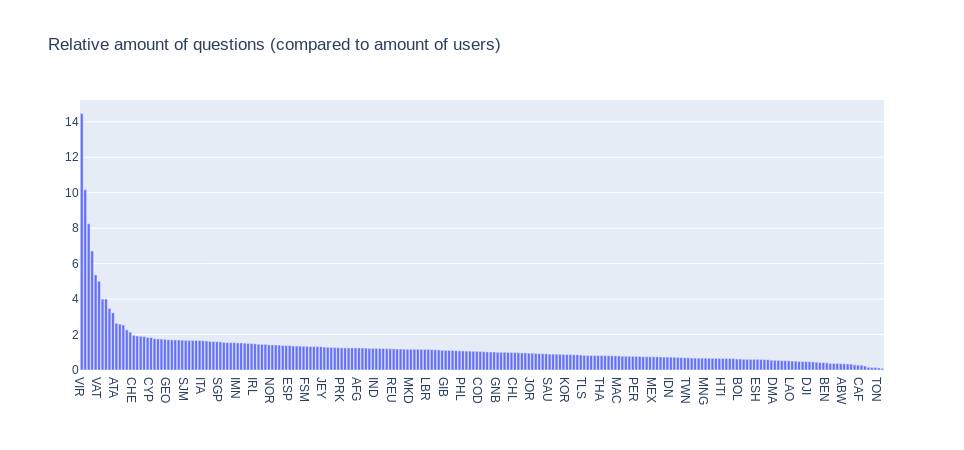

In [20]:
"""Plot relative question counts as barplot to see the distribution"""
fig = go.Figure([go.Bar(x=question_counts_and_users_count_df.sort_values("proportion", ascending=False).iso3,
                        y=question_counts_and_users_count_df.sort_values("proportion", ascending=False).proportion,
                       text=question_counts_and_users_count_df.sort_values("proportion", ascending=False)["country_name"])])
fig.update_layout(
    title_text = 'Relative amount of questions (compared to amount of users)'
)

fig.show()

Indeed, it seems like we have problems with some really small countries having very large question/user ratios. This could be explained due to statistical reasons, since it's much easier for a country to be an outlier if the sample size is small enough than for instance for India or the US. Perhaps the distribution also reflects some real effects like lots of researchers living in the area (Like Antarctica). In any case, we are not very interested in the smallest countries in the dataset, so let's try removing the countries with under 1000 users. 

In [21]:
reduced_q_u_counts_df = question_counts_and_users_count_df[question_counts_and_users_count_df["count"] > 1000]

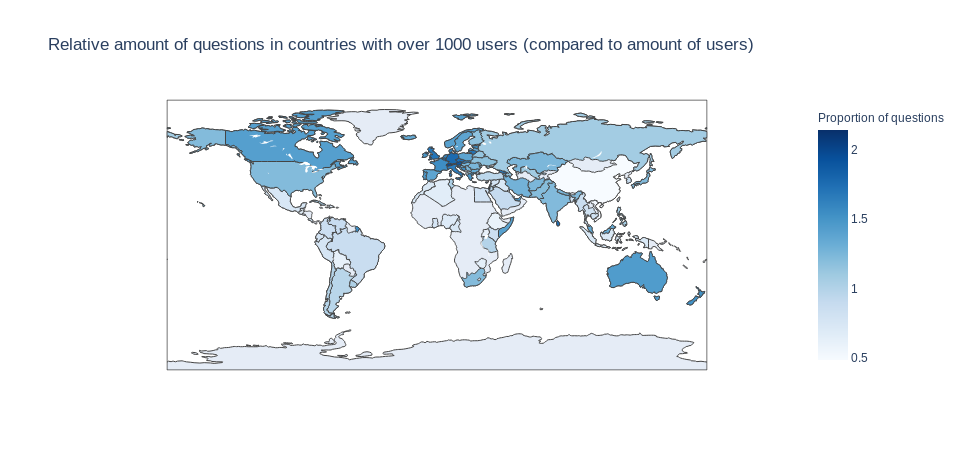

In [22]:
"""Relative question counts restricted to countries with enough users"""
fig = go.Figure(data=go.Choropleth(
    locations=reduced_q_u_counts_df["iso3"], # Spatial coordinates
    z = reduced_q_u_counts_df["proportion"], # Data to be color-coded
    text = reduced_q_u_counts_df[["country_name", "count", "q_count"]],
    colorscale = 'Blues',
    colorbar_title = "Proportion of questions",
))

fig.update_layout(
    title_text = 'Relative amount of questions in countries with over 1000 users (compared to amount of users)'
)

fig.show()

Now we see much clearer patterns, such as users in central Europe emerging as the most active users in asking questions. Again, China stands out, this time by having a very small question/user proportion. Could be explained by language barriers or restrictions on usage? 

An important note to make is that the relative amount of questions / users may not be a very good metric for countries where the amount of users has changed in the past four years considerably. We should instead take in to account the amount of time each user has been on stackoverflow during the four-year period, that is, calculate the amount of questions per user per year. Let's study the creation date distribution of the users next.

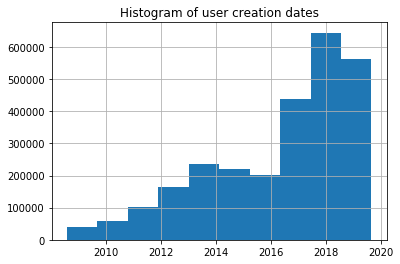

In [38]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure()
plt.title("Histogram of user creation dates")
users_df["creation_date"].hist()

Definitely the amount of users has changed and the rate seems to have increased quite dramatically since the beginning of 2016. Thus, we need to keep this in mind in the future analysis.

In [30]:
print("Users registered in 2016: ", sum([x.year == 2016 for x in users_df.creation_date]))
print("Users registered in 2017: ", sum([x.year == 2017 for x in users_df.creation_date]))

Users registered in 2016:  247293
Users registered in 2017:  589846


Actually the large jump in registered users between 2016 and 2017 is somewhat peculiar, and should maybe be investigated in future analysis. 

## More precise Analysis  on  Chinese StackOverflow Users

In [25]:
"""
The result of survey generally reflects the users distirbution and their features.
However, one may wonder why China as a big country only well less involved in this
survey. This may due to some actual facts that China do large scale internet censorship
which may slow the users of using SO from mainland China. This causes that the actual 
number of users of SO in China is significently lower than other countries like India,
USA or Brazil.  (actaully between Norway and Iran)
Here we want to use machine learning algorithm to give a preditction of the real 
potential users community of SO in China.

""";




In [26]:
country=pd.read_pickle('./misc/country_for_ML.pkl')

country[country['country']=='China']

country  UserNumber code  population18(million)  User per capita index  \
34   China         316  CHN                1392.73               0.226893   

   Internet Users  Rank # users  Internet Percentage Rank percentage  \
34    765,367,947           1.0                 54.3             116   

    2019 EF Score  gdp per capita Country Code  
34          53.44     8869.559713          CHN

In [27]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler

In [28]:
features=['population18(million)','Internet Percentage','2019 EF Score','gdp per capita']

country_features = country[features].to_numpy()
country_users=country['UserNumber'].to_numpy()

scaler = MinMaxScaler()
scaler.fit(country_features)
country_features=scaler.transform(country_features)

china_feature=np.expand_dims(country_features[34,:],0)
china_users=country_users[34]
country_features = np.delete(country_features, 34, 0)
country_users=np.delete(country_users, 34, 0)

X_train, X_test, y_train, y_test = train_test_split(
    country_features, country_users, test_size=0.3, random_state=1)

In [29]:
alphas = []
scores = []
# hyperparameter optimization
def hyper_ridge(X, y):
    best_alpha = 0
    highest_score = float('-inf')
    for alpha in np.linspace(0,10,500):
        ridge_reg = Ridge(alpha=alpha)
        alphas.append(alpha)
        curr_score = cross_val_score(ridge_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
        scores.append(curr_score)
        if curr_score > highest_score:
            highest_score = curr_score
            best_alpha = alpha
    return best_alpha

In [30]:
alpha_optimal = hyper_ridge(X_train, y_train)
ridge_reg_optimal = Ridge(alpha=alpha_optimal)
ridge_reg_optimal.fit(X_train, y_train)

Ridge(alpha=0.4609218436873747, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

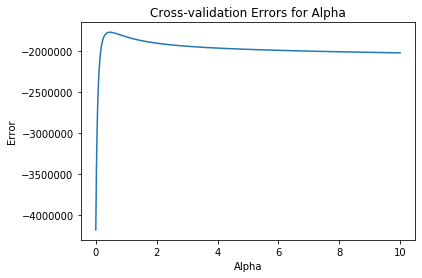

In [31]:
plt.xlabel('Alpha')
plt.ylabel('Error')
plt.title('Cross-validation Errors for Alpha')
plt.plot(alphas, scores)

In [37]:
predict_value=ridge_reg_optimal.predict(china_feature)[0]
print("""Chinese users number of the survey should be {0} according to the linear regression,\
thus 14 times larger than the actual number=316.""".format(predict_value))

Chinese users number of the survey should be 4824.908144651128 according to the linear regression,thus 14 times larger than the actual number=316.


In [33]:
#Actual chinese users number of survey 
country[country['country']=='China']

country  UserNumber code  population18(million)  User per capita index  \
34   China         316  CHN                1392.73               0.226893   

   Internet Users  Rank # users  Internet Percentage Rank percentage  \
34    765,367,947           1.0                 54.3             116   

    2019 EF Score  gdp per capita Country Code  
34          53.44     8869.559713          CHN

In [34]:
"""
According to our prediction , China should have a second largest users group on SO, thus
behind USA and before UK and India. But the actual ranking is 34st.

To do next for milestone3: draw 95% confidence intervals of the regression result


""";

country.head(5)

country  UserNumber code  population18(million)  \
0   United States       13445  USA             327.167434   
1  United Kingdom        4520  GBR              66.488991   
2           India        4151  IND            1352.617328   
3         Germany        3848  DEU              82.927922   
4          Canada        2013  CAN              37.058856   

   User per capita index Internet Users  Rank # users  Internet Percentage  \
0              41.095166    244,090,854           3.0                75.23   
1              67.981179     62,621,016          11.0                94.62   
2               3.068865    461,347,554           2.0                34.45   
3              46.401742     69,304,405           9.0                84.40   
4              54.319000     33,950,632          22.0                92.70   

  Rank percentage  2019 EF Score  gdp per capita Country Code  
0              68          85.00    60157.715455          USA  
1              18          85.00    40987.781445          GBR  
2             145          55.49     1908.785850          IND  
3              36          63.77    45106.709185          DEU  
4              22          85.00    44520.125233          CAN

# Plans for the future
In this notebook, we have showed that there are definitely interesting patterns in the dataset, and there are lots of potential directions to go from here. Combining the Stackoverflow data and the survey data with population or education level data, for instance, should allow us to perform quite rich analyses on a by-country basis, and analysis combining the two main datasets is indeed the clearest next step. Another important step is to do more sophisticated analysis on the questions asked and answered. Our plan is to explore whether there are patterns with the geographical distribution, for instance if questions from certain countries tend to be answered by people from some certain other countries. In general the "flow of information" with who asks and who answers questions and Stackoverflow as a kind of social network is an interesting idea for us, and we would like to explore it further. A third possiblity for future development is doing more sophisticated analysis on the survey data. We have an idea of doing clustering with the people answering the survey to identify groups of users. This would be interesting if the results of the clustering turn out to be somehow semantically meaningful, which would allow us to identify different programmer types and their distribution around the world, for instance. A fourth idea for more advanced analysis, briefly mentioned already, would be to use simple machine learning methods like linear regression to identify potentials for growth for Stackoverflow. Here the extra datasets on education levels etc. should be quite important. 

There are also some issues we have to deal with. Using the Stackoverflow data on an ordinary laptop is completely doable, but we have to be careful with memory limitations as the datasets are quite large. Analyzing the Stackoverflow data can also have some small difficulties with normalizing the data, as mentioned in the last section of the notebook. The categorical nature of the survey data is also somewhat of a problem, especially when attempting to do clustering on them. K-modes clustering could be the solution here, but still it's not clear that we will get any meaningful results. A similar uncertainty exists with the question/answer flow patterns, since it is possible that nothing of interest will be found. We will accordingly try to get preliminary results of these analyses as soon as possible to allow us to adjust the direction of the project accordingly. As we get closer to Milestone 3, our work should be focused increasingly on delivering actual results for the final report/data story. 